# Task 4: Finding the lowest eigenvalue of a 4x4 matrix using VQE-like circuits

Resources:<br>
[1] A. Peruzzo et al., Nature Communications, "A variational eigenvalue solver on a photonic quantum processor" (2014). https://www.nature.com/articles/ncomms5213 <br>
[2] Michał Stęchły, "Variational Quantum Eigensolver explained". https://www.mustythoughts.com/variational-quantum-eigensolver-explained <br>
[3] Davit Khachatryan, "Variational quantum eigensolver". https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb <br>
[4] Dr. Michael Goerz, "Decomposing Two-Qubit Hamiltonians into Pauli-Matrices". https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html <br>
[5] The Qiskit Textbook. https://qiskit.org/textbook/preface.html

Task 4: 
Find the lowest eigenvalue of the following matrix:

[1 0 0 0; <br>
0 0 -1 0; <br>
0 -1 0 0; <br>
0 0 0 1]<br>

using VQE-like circuits, created by yourself from scratch.


Solution:

In this problem, we build different parts for the given vqe hybrid system[1]:
<br>
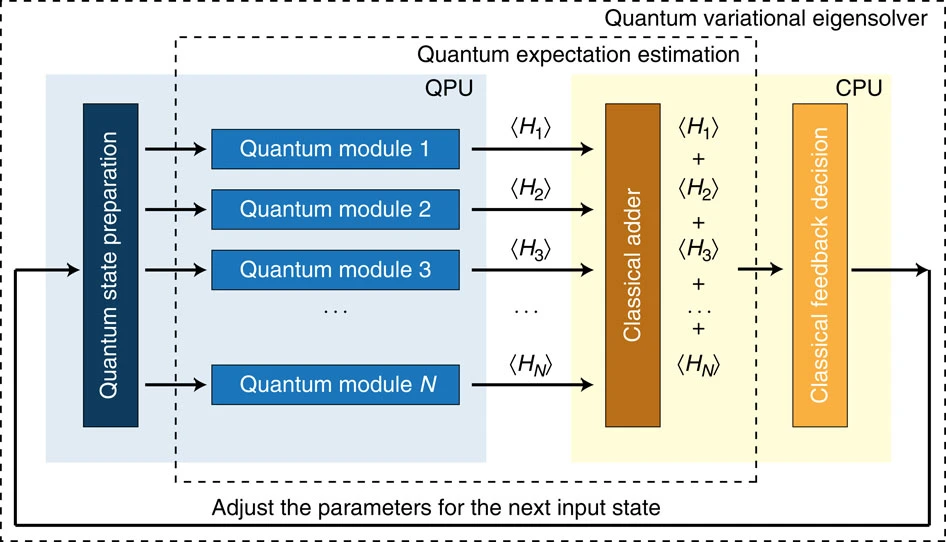
<br>
The motivation for this notebook comes from [2], while the coding approach extends the idea of [3] for 2 qubit, from 1 qubit. Most of the quantum circuitry code is used with the help of [5]. Numerical calculation was done using NumPy and plotting was done using matplotlib.Finally the matrix decomposition part was done with the help of [4].<br>

Please go through the resources for detailed theoretical explanations, or stick to this notebook if you just want to see the implementation of the problem in qiskit!

We know that any $4\times4$ hamiltonian can be written as a sum of pauli terms: $$ H = \sum_{i,j=1,x,y,z} a_{i,j}( \sigma_i \otimes \sigma_j), \quad a_{i,j} = \frac{1}{4} Trace[( \sigma_i \otimes \sigma_j ) H]$$ with real coefficients $a_{i,j}$. The $\sigma_i$ terms for $i = 1, x, y, z$ are the usual 1 qubit pauli matrices: $$\sigma_1 = \begin{pmatrix} 1 & 0 \\ 0 & 1 \end{pmatrix},
\sigma_x = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix},
\sigma_y = \begin{pmatrix} 0 &-i \\ i & 0 \end{pmatrix},
\sigma_z = \begin{pmatrix} 1 & 0 \\ 0 &-1 \end{pmatrix}.$$

So firstly, we need to decompose our given matrix into pauli terms. After importing our packages, we define the our matrix H and the function for decomposing into pauli matrices:

In [1]:
#imports
import numpy as np
from qiskit import *


In [2]:
#define our matrix H
H = np.array([[1, 0, 0, 0],
              [0, 0,-1, 0],
              [0,-1, 0, 0],
              [0, 0, 0, 1]])


In [3]:
#decompose funtion
def pauli_decompose(A):
    """
    Decomposes matrix A into pauli terms
    
    Input
    -----
    A: 2 qubit hamiltonian matrix of shape (4x4)   

    Returns
    -------
    A dictionary with pauli terms as keys and the coefficients a_ij as values

    """
    a = []
    A = []
    
    #define I, X, Y, Z matrices
    I = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    X = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    Y = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    Z = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    pauli1q = [I, X, Y, Z]
    
    pauliTerms1q = ["I", "X", "Y", "Z"]
    
    for i in range(4):
        for j in range(4):
            A.append(pauliTerms1q[i]+pauliTerms1q[j])
            tensor_product = np.kron(pauli1q[i], pauli1q[j])
            a.append(0.25 * np.real(np.trace(np.dot(tensor_product, H))))
    return dict(zip(A, a))

print(pauli_decompose(H))

{'II': 0.5, 'IX': 0.0, 'IY': 0.0, 'IZ': 0.0, 'XI': 0.0, 'XX': -0.5, 'XY': 0.0, 'XZ': 0.0, 'YI': 0.0, 'YX': 0.0, 'YY': -0.5, 'YZ': 0.0, 'ZI': 0.0, 'ZX': 0.0, 'ZY': 0.0, 'ZZ': 0.5}


Now let's check the original minimum eigenvalue of H:

In [4]:
from numpy import linalg
w, v = linalg.eig(H)
print(min(w))

-1.0


The ansatz we'll be using is (RX I) CX (HI) |00>, where angle in R_x is our variational parameter. And by varying the angle in R_x, we will implement the vqe algorithm. 

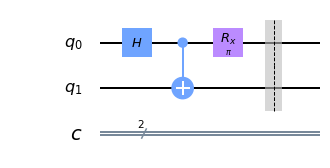

In [5]:
#quantum state/ansatz preparation
def create_ansatz(circuit, parameters):
    """
    Quantum state preparation
    
    Inputs
    ------
    circuit: a QuantumCircuit circuit object
    parameters: The variational parameter dictionary {"R_x" : theta}

    Returns
    -------
    The given quantum circuit with the desired quantum state/anstatz prepared

    """
    #entangle the qubits
    circuit.h(circuit.qubits[0])
    circuit.cx(circuit.qubits[0], circuit.qubits[1])
    
    #apply the gate Rx with variational parameter theta
    circuit.rx(float(parameters["R_x"]), circuit.qubits[0])
    circuit.barrier()
    
    return circuit

qc = create_ansatz(QuantumCircuit(2, 2), {"R_x": np.pi})
qc.draw("mpl")


Now for the quantum expectation estimation part, first we need to create a quantum circuit that makes some measurement. But the catch is, in a quantum hardware we can only measure in the z-basis.<br>

Consequently, we make slight modifications in our circuit. So now, even if we have $\sigma_x$ or $\sigma_y$ operator for our qubit, we can still make the standard z-basis measurement *after* applying those *modifications (read: gates)* so that out standard basis measurement probabilitites correspond to the desired probabilities if we had actually measured in x-basis or y-basis.

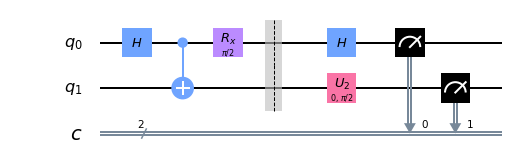

In [6]:
#create vqe-like circuit
def create_vqe_circuit(parameters, pauli):
    """creates the vqe ckt with 2 qubits & 2 classical bits"""
    """
    Creates the a quantum circuit with 2 qubits & 2 classical bits, for quantum expectation estimation
    
    Inputs
    ------
    parameters: The variational parameter dictionary {"R_x" : theta}
    pauli: The pauli string "II"/"XX"/"YY"/..
    
    Returns
    -------
    A quantum circuit ready for quantum expectation estimation with desired quantum state/ansatz

    """
    #the circuit
    circuit = QuantumCircuit(2, 2)
    
    #prepare ansatz
    circuit = create_ansatz(circuit, parameters)
          
    #the *modifications*
    for i, gate in enumerate(pauli):
        if gate == "X":
            circuit.h(circuit.qubits[i]) 
        elif gate == "Y":
            circuit.u2(0, np.pi/2, circuit.qubits[i])
        else:
            pass #do nothing for gate =="I"
        
    #the standard z-basis measurements
    circuit.measure(circuit.qubits[0], circuit.clbits[0])
    circuit.measure(circuit.qubits[1], circuit.clbits[1])
    
    return circuit

qc = create_vqe_circuit({"R_x" : np.pi/2}, "XY")
qc.draw("mpl")

Now have to design the Quantum Expectation Estimation part. This function uses the previously created quantum circuit to estimate the expectation values of each part of the hamiltonian matrix, H (i.e. the "II", "XX", .. part) <br>

We use the qasm_simulator for this task. We can either do the calculations in a noisy environment, or an ideal noise-free environment. For the noisy simulation, we need to apply a special noise mitigation filter to get some sort of *sensible* result. Without the noise cancellation part, the algorithm spits out results that are just bonkers!

In [7]:
def quantum_module(parameters, pauli, shots=1000, Noise=False, Noise_model=None):
    """
    Creates the quantum module for quantum expectation estimation part
    
    Inputs
    ------
    parameters: The variational parameter dictionary {"R_x" : theta}
    pauli: The pauli string "II"/"XX"/"YY"/..
    shots: int, # of shots
    Noise: boolean, set True for calculation in noisy environment
    Noise_model: qiskit NoiseModel object 

    Returns
    -------
    Expectation value of the pauli term

    """
    if pauli == "II":
        return 1
    else:
        circuit = create_vqe_circuit(parameters, pauli)

        
    backend = Aer.get_backend("qasm_simulator")
    
    if Noise != False: #simulate in a noisy environment
        
        #calibrate a measurement filter for noise mitigation
        from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
        
        qr = qiskit.QuantumRegister(2)
        meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
        job = qiskit.execute(meas_calibs, backend=backend, shots=shots, noise_model=Noise_model)
        cal_results = job.result()
        meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
    
        #simulate with noise
        from qiskit.test.mock import FakeVigo
        basis_gates = noise_model.basis_gates
        device_backend = FakeVigo()
        coupling_map = device_backend.configuration().coupling_map
        result_noise = execute(circuit, backend, noise_model=noise_model, shots = shots, coupling_map=coupling_map,
                               basis_gates=basis_gates).result()
        
        #mitigate the noisy result with the previously calibrated filter
        #get the filter object
        meas_filter = meas_fitter.filter
        
        #apply the mitigation filter to the noisy results
        mitigated_results = meas_filter.apply(result_noise)
        counts = mitigated_results.get_counts(0)
        
    else: #simulate in a noise-free environment
        counts = execute(circuit, backend, shots=shots).result().get_counts()
    
    
    #for the 2 qubit case, in X and Y basis measurements (actually cleverly done in z-basis), only |00> and |11> states have
    #the eigenvalue "+1", while the other 2 states |01> and |10> have the eigenvalue "-1".
        
    def expectation_value(counts, shots):
        """returns expectation value"""
        exp = 0
        if "00" in counts:
            exp += counts["00"]

        if "01" in counts:
            exp -= counts["01"]

        if "10" in counts:
            exp -= counts["10"]

        if "11" in counts:
            exp += counts["11"]

        return exp/shots
        
    return expectation_value(counts, shots)

print(quantum_module({"R_x" : np.pi/2}, "XY", shots=100, Noise=False, Noise_model=None))

0.04


Now we design the classical adder block, which just adds up the different expectation values from different quantum modules.

In [8]:
def classical_adder(theta, shots=1000, Noise=False, Noise_model=None):
    """
    Adds up different energy values for each pauli terms, given the variational parameter
    
    Inputs
    ------
    H: 2 qubit hamiltonian matrix of shape (4x4)  
    theta: variational parameter for R_x
    shots: int, # of shots
    Noise: boolean, set True for calculation in noisy environment
    Noise_model: qiskit NoiseModel object 

    Returns
    -------
    Energy of the hamiltonian

    """    
    d = pauli_decompose(H)

    pauliTerms2q = list(d.keys())
    pauliCoeff2q = list(d.values())
    
    Energy = 0
    
    parameter = dict()
    parameter["R_x"] = float(theta)
    
    for j in range(len(d)):
        if pauliCoeff2q[j] != 0:
            Energy += np.real(pauliCoeff2q[j]) *  quantum_module(parameter, pauliTerms2q[j], shots=shots, Noise=Noise, Noise_model=Noise_model)
    
    return Energy

print(classical_adder(np.pi/2, shots=100, Noise=False, Noise_model=None))

0.03


Finally, our vqe function:

In [9]:
def vqe(H, shots=1000, Noise=False, Noise_model=None, Optimizer=None):
    """
    Using VQE algorithm, calculates the minimum eigenvalue for the hamiltonian H
    
    Inputs
    ------
    H: 2 qubit hamiltonian matrix of shape (4x4)  
    shots: int, # of shots
    Noise: boolean, set True for calculation in noisy environment
    Noise_model: qiskit NoiseModel object 
    Optimizer: qiskit optimizer object

    Returns
    -------
    Tuple of the value of the variational parameter, the upper bound of the minimum eigenvalue of H, number of iterations

    """
    optimizer = Optimizer
    #randomly initializing our variational parameter, theta
    theta = np.random.rand(1)
    
    #optimize using the Optimizer passed into the function
    ret = optimizer.optimize(num_vars=len(theta), objective_function=classical_adder, initial_point=theta)
    
    return ret

Lets also write a few helper functions for better analysis.

In [10]:
def create_noise_model():
    """
    Returns
    -------
    Basic noise model object
    
    """
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.test.mock import FakeVigo
    device_backend = FakeVigo()
    coupling_map = device_backend.configuration().coupling_map
    noise_model = NoiseModel.from_backend(device_backend)
    
    return noise_model

def initialize_optimizer(max_iter, tol, Optimizer="POWELL"):
    """
    Inputs
    ------
    Optimizer: str, name of the desired optimizer
    max_iter: int, maximum iterations
    tol: float, tolerance 
    
    Returns
    -------
    Optimizer object
    
    """
    
    from qiskit.aqua.components.optimizers import POWELL

    if Optimizer == "COBYLA":
        from qiskit.aqua.components.optimizers import COBYLA
        opt = COBYLA(maxiter=max_iter, tol=tol)
    elif Optimizer == "POWELL":
        from qiskit.aqua.components.optimizers import POWELL
        opt = POWELL(maxiter=max_iter, tol=tol)
        
    return opt

def plot_loss_function(H, shots=1000, Noise=False, Noise_model=None, num_points=128):
    """
    Plots loss function
    
    Inputs
    ------
    H: 2 qubit hamiltonian matrix of shape (4x4)  
    shots: int, # of shots
    Noise: boolean, set True for calculation in noisy environment
    Noise_model: qiskit NoiseModel object 
    num_points = int, number of points to generate the plot
    
    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt


    points = num_points
    Rx_values = np.linspace(0, np.pi*2, points)
    Energy = np.zeros(Rx_values.size)
    
    d = pauli_decompose(H)

    pauliTerms2q = list(d.keys())
    pauliCoeff2q = list(d.values())
     
    
    for i in range(points):
        for j in range(len(pauliTerms2q)):
            if pauliCoeff2q[j] != 0:
                Energy[i] += np.real(pauliCoeff2q[j]) * quantum_module({"R_x" : Rx_values[i]}, pauliTerms2q[j],
                                                                       shots=shots, Noise=Noise, Noise_model=Noise_model)
    
    
    plt.plot(Rx_values, Energy)
    

    
    
    plt.xlabel(r"Variational parameter $R_x \theta$")
    plt.ylabel(r"Energy")
    plt.legend(r"")
    plt.show()
    print("Simulation results\n------------------\nMinimum Energy : ",
          min(Energy), r", at R_x = ", Rx_values[np.argmin(Energy)]/np.pi, "* pi\n")
        

Before applying any classical optimizer, to get a feel about how the expectation value changes with the variational parameter, lets plot the 

Simulating without noise:


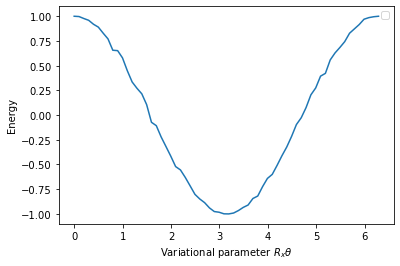

Simulation results
------------------
Minimum Energy :  -1.0 , at R_x =  1.015873015873016 * pi

Simulating with noise:


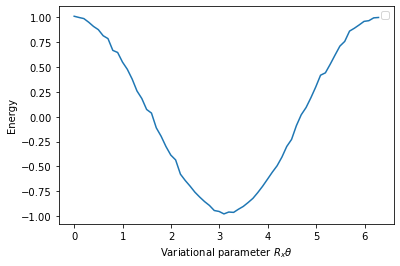

Simulation results
------------------
Minimum Energy :  -0.9788768766239904 , at R_x =  0.9841269841269842 * pi



In [11]:
print("Simulating without noise:")
plot_loss_function(H,  num_points = 64)

#define noise model
noise_model = create_noise_model()

print("Simulating with noise:")
plot_loss_function(H, Noise = True, Noise_model = noise_model, num_points = 64)


2 things to notice: <br>
i. *Without* noise, we get the almost accurate result of -1, but *with noise* our result is slightly off. But nonetheless, workable.<br>
ii. In both scenarios, the Energy vs $R_x \theta$ is a convec function, with a well defined minima. So we can safely apply any optimizer to reach that minima, within a certain tolerance.

Now, lets try with an optimizer and formally solve this problem with vqe.

In [12]:
#initialize our optimizer
max_iter = 500
tol = 1e-4
opt = "POWELL"
optimizer = initialize_optimizer(max_iter, tol, Optimizer=opt)

results = vqe(H, shots=128, Noise=True, Noise_model=noise_model, Optimizer=optimizer)
print("Simulating with "+opt+" optimizer, with a tolerance of : "+str(tol)+"\n")
print("Simulation results\n------------------\nMinimum Energy : ", results[1], r", at R_x = ", results[0]/np.pi, "* pi, After ", results[2], " iterations\n")

Simulating with POWELL optimizer, with a tolerance of : 0.0001

Simulation results
------------------
Minimum Energy :  -1.0 , at R_x =  [0.99171501] * pi, After  65  iterations



In [13]:
print("So the minimum eigenvalue of the matrix \n\n", H,"\n\nis : ", results[1],
      "with an error of : ", np.abs((results[1] - min(w))/min(w))*100, "%\n" )

So the minimum eigenvalue of the matrix 

 [[ 1  0  0  0]
 [ 0  0 -1  0]
 [ 0 -1  0  0]
 [ 0  0  0  1]] 

is :  -1.0 with an error of :  0.0 %

